In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
!pip install git+https://github.com/huggingface/transformers
from transformers import AutoTokenizer
from transformers import AutoModel
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AdamW
import torch
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

import numpy as np
import pandas as pd
from pandas import DataFrame
import itertools
import string
import os
import nltk

from sklearn.model_selection import train_test_split, StratifiedKFold


from google.colab import drive 
drive.mount('/content/drive')

In [6]:
import re

In [10]:
import os
from operator import itemgetter

# Define Model

In [42]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [43]:
embed_dim = 32
latent_dim = 128
num_heads = 4
sequence_length = 25
vocab_size = 80


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [44]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 32)     3360        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 32)     25280       positional_embedding[0][0]       
________________________________________________________________________________________

# Inspect Input

In [2]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/CELEX/CELEX_word_raw.csv', index_col=0)
df

,index,word,frequency,lemma_index,Tag,change
0,1,a,413887.0,1.0,X,@
1,2,a,422336.0,2.0,N;SG,@
2,3,A,422334.0,4.0,X,@
3,4,a,8448.0,3.0,X,@
4,5,AA,52.0,5.0,N;SG,@
...,...,...,...,...,...,...
160590,160591,underbid,0.0,49096.0,V.PTCP;PST,IRR
160591,160592,undercut,3.0,49108.0,V.PTCP;PST,IRR
160592,160593,upset,34.0,49689.0,V.PTCP;PST,IRR
160593,160594,wed,1.0,51069.0,V.PTCP;PST,IRR


In [ ]:
df['word'][0] * int(df['frequency'][0])

In [8]:
type(int(df['frequency'][0]))

int

In [11]:
df[df['Tag'] == 'V;PST']

,index,word,frequency,lemma_index,Tag,change
16,17,abandoned,124.0,12.0,V;PST,@+ed
21,22,abased,0.0,15.0,V;PST,@+d
25,26,abashed,3.0,17.0,V;PST,@+ed
30,31,abated,5.0,18.0,V;PST,@+d
45,46,abbreviated,6.0,25.0,V;PST,@+d
...,...,...,...,...,...,...
159567,159568,undercut,3.0,49108.0,V;PST,IRR
159639,159640,upset,34.0,49689.0,V;PST,IRR
159823,159824,wed,1.0,51069.0,V;PST,IRR
159848,159849,wet,2.0,51260.0,V;PST,IRR


In [ ]:
df_verb[499:544]

In [13]:
df_verb = df[df['Tag'].isin(['V.PTCP;PST','V;PST','V;NFIN','V;3;SG;PRS','V.PTCP;PRS'])]
df_verb

,index,word,frequency,lemma_index,Tag,change
14,15,abandon,65.0,12.0,V;NFIN,@
16,17,abandoned,124.0,12.0,V;PST,@+ed
17,18,abandoning,79.0,12.0,V.PTCP;PRS,@+ing
19,20,abandons,16.0,12.0,V;3;SG;PRS,@+s
20,21,abase,0.0,15.0,V;NFIN,@
...,...,...,...,...,...,...
160590,160591,underbid,0.0,49096.0,V.PTCP;PST,IRR
160591,160592,undercut,3.0,49108.0,V.PTCP;PST,IRR
160592,160593,upset,34.0,49689.0,V.PTCP;PST,IRR
160593,160594,wed,1.0,51069.0,V.PTCP;PST,IRR


In [21]:
corpus = []
for index, row in df_verb.iterrows():
  verb = row['word'] + ' '
  text = verb* int(row['frequency'])
  corpus.append(text)

In [75]:
a = 'apple'
a[0]

'a'

In [ ]:
corpus[0]

In [53]:
encoder = Encoder(vocab_size= 10000,pct_bpe=1.5, ngram_max=2)
encoder.fit(['going','knowing','going knowing', 'going','eating','eating, going'])
example = "eating"
print(encoder.tokenize(example))
print(next(encoder.transform([example])))
print(next(encoder.inverse_transform(encoder.transform([example]))))


['__sow', 'ea', 'ti', 'ng', '__eow']
[2, 21, 23, 8, 3]
eating


In [ ]:
df_verb['frequency'] = df_verb['frequency'].astype(int)

In [67]:
corpus2 = list(itertools.chain(*corpus))

In [70]:
vocab = build_vocab(corpus2)

In [ ]:
vocab

In [ ]:
get_stats(vocab)

In [18]:
num_merges = 50  # Hyperparameter
for i in range(num_merges):

    pairs = get_stats(vocab)  # Step 2

    if not pairs:
        break

    # step 3
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)


In [22]:
df_ed['last'] = ['-' + i[-3:] for i in df_ed['inflection']]
df_ed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Index,root,inflection,tag,rule,reg,diff,count,last
9,9,strong-arm,strong-armed,V;PST,+ed,Regular,-ed,1605,-med
11,11,beshout,beshouted,V;PST,+ed,Regular,-ed,1605,-ted
17,17,embroid,embroided,V;PST,+ed,Regular,-ed,1605,-ded
29,29,bulk,bulked,V;PST,+ed,Regular,-ed,1605,-ked
44,44,sheriff,sheriffed,V;PST,+ed,Regular,-ed,1605,-fed
...,...,...,...,...,...,...,...,...,...
9954,9954,troop,trooped,V;PST,+ed,Regular,-ed,1605,-ped
9965,9965,boast,boasted,V;PST,+ed,Regular,-ed,1605,-ted
9969,9969,tweag,tweaged,V;PST,+ed,Regular,-ed,1605,-ged
9972,9972,decrown,decrowned,V;PST,+ed,Regular,-ed,1605,-ned


In [30]:
df_ed[df_ed['last'] == '-ted']

,Index,root,inflection,tag,rule,reg,diff,count,last
11,11,beshout,beshouted,V;PST,+ed,Regular,-ed,1605,-ted
142,142,noint,nointed,V;PST,+ed,Regular,-ed,1605,-ted
334,334,reassault,reassaulted,V;PST,+ed,Regular,-ed,1605,-ted
380,380,reindent,reindented,V;PST,+ed,Regular,-ed,1605,-ted
392,392,deprotect,deprotected,V;PST,+ed,Regular,-ed,1605,-ted
...,...,...,...,...,...,...,...,...,...
9693,9693,overcompliment,overcomplimented,V;PST,+ed,Regular,-ed,1605,-ted
9886,9886,backfoot,backfooted,V;PST,+ed,Regular,-ed,1605,-ted
9938,9938,flabaghast,flabaghasted,V;PST,+ed,Regular,-ed,1605,-ted
9949,9949,wright,wrighted,V;PST,+ed,Regular,-ed,1605,-ted


In [31]:
#df_double = df[df['rule'] == 'double spell']
df_double[df_double['diff'] == '-ted']

,Index,root,inflection,tag,rule,reg,diff,count
149,149,sot,sotted,V;PST,double spell,Irregular,-ted,43
314,314,clot,clotted,V;PST,double spell,Irregular,-ted,43
1151,1151,screenshot,screenshotted,V;PST,double spell,Irregular,-ted,43
1957,1957,double-shot,double-shotted,V;PST,double spell,Irregular,-ted,43
2070,2070,flit,flitted,V;PST,double spell,Irregular,-ted,43
2133,2133,snot,snotted,V;PST,double spell,Irregular,-ted,43
2460,2460,snippet,snippetted,V;PST,double spell,Irregular,-ted,43
3312,3312,electroblot,electroblotted,V;PST,double spell,Irregular,-ted,43
3992,3992,immit,immitted,V;PST,double spell,Irregular,-ted,43
5228,5228,leaflet,leafletted,V;PST,double spell,Irregular,-ted,43


#BPE attemp
http://ethen8181.github.io/machine-learning/deep_learning/subword/bpe.html

In [2]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/CELEX/CELEX_word_raw.csv', index_col=0)
df_verb = df[df['Tag'].isin(['V.PTCP;PST','V;PST','V;NFIN','V;3;SG;PRS','V.PTCP;PRS'])]

In [3]:
vocab_dict = {}
for index, row in df_verb.iterrows():
  k1 = list(row['word']) + ['</w>']
  key = " ".join(k1)
  num = row['frequency'] + 1
  vocab_dict[key] = num

In [4]:
def get_pair_stats(vocab): #-> Dict[Tuple[str, str], int]:
    """Get counts of pairs of consecutive symbols."""

    pairs = {}
    for word, frequency in vocab.items():
        symbols = word.split()

        # count occurrences of pairs
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            current_frequency = pairs.get(pair, 0)
            pairs[pair] = current_frequency + frequency

    return pairs
def merge_vocab(best_pair,vocab_in): #-> Dict[str, int]:
    """Step 3. Merge all occurrences of the most frequent pair"""

    vocab_out = {}

    # re.escape
    # ensures the characters of our input pair will be handled as is and
    # not get mistreated as special characters in the regular expression.
    pattern = re.escape(' '.join(best_pair))
    replacement = ''.join(best_pair)

    for word_in in vocab_in:
        # replace most frequent pair in all vocabulary
        word_out = re.sub(pattern, replacement, word_in)
        vocab_out[word_out] = vocab_in[word_in]

    return vocab_out

In [7]:
bpe_codes = {}
num_merges = 30  # hyperparameter
for i in range(num_merges):
    #print('\niteration', i)
    pair_stats = get_pair_stats(vocab_dict)
    if not pair_stats:
        break

    best_pair = max(pair_stats, key=pair_stats.get)
    bpe_codes[best_pair] = i

    #print('vocabulary: ', vocab)
    #print('best pair:', best_pair)
    vocab_dict = merge_vocab(best_pair, vocab_dict)

#print('\nfinal vocabulary: ', vocab)
print('\nbyte pair encoding: ', bpe_codes)


byte pair encoding:  {('s', '</w>'): 0, ('i', 'n'): 1, ('in', 'g'): 2, ('ing', '</w>'): 3, ('e', '</w>'): 4, ('d', '</w>'): 5, ('i', 's</w>'): 6, ('a', 's</w>'): 7, ('e', 'n'): 8, ('e', 'd</w>'): 9, ('b', 'e</w>'): 10, ('w', 'as</w>'): 11, ('b', 'e'): 12, ('en', '</w>'): 13, ('h', 'a'): 14, ('e', 'r'): 15, ('r', 'e'): 16, ('e', 's</w>'): 17, ('c', 'o'): 18, ('t', '</w>'): 19, ('t', 'ing</w>'): 20, ('be', 'en</w>'): 21, ('a', 'n'): 22, ('s', 't'): 23, ('k', 'ing</w>'): 24, ('l', 'l'): 25, ('d', 'o'): 26, ('v', 'e</w>'): 27, ('a', 'r'): 28, ('o', 'w'): 29}


In [8]:
def get_pairs(word):# -> Set[Tuple[str, str]]:
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char

    return pairs
def create_new_word(word, pair_to_merge): #-> List[str]:
    first, second = pair_to_merge
    new_word = []
    i = 0
    while i < len(word):
        try:
            j = word.index(first, i)
            new_word.extend(word[i:j])
            i = j
        except ValueError:
            new_word.extend(word[i:])
            break

        if i < len(word) - 1 and word[i + 1] == second:
            new_word.append(first + second)
            i += 2
        else:
            new_word.append(first)
            i += 1

    return new_word
from typing import Dict, Tuple, List, Set

def encode(original_word: str, bpe_codes: Dict[Tuple[str, str], int]) -> List[str]:
    if len(original_word) == 1:
        return original_word

    word = list(original_word)
    word.append('</w>')

    while True:
        pairs = get_pairs(word)
        bpe_codes_pairs = [(pair, bpe_codes[pair]) for pair in pairs if pair in bpe_codes]
        if not bpe_codes_pairs:
            break

        pair_to_merge = min(bpe_codes_pairs, key=itemgetter(1))[0]
        word = create_new_word(word, pair_to_merge)

    return word

In [13]:
original_word = 'churches'
encode(original_word, bpe_codes)

['c', 'h', 'u', 'r', 'c', 'h', 'es</w>']

## Use BPE encoding for tokenizer

In [21]:
df_train = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Past_Tense_train_data.csv', index_col=0)
df_test = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Past_Tense_test_data.csv',index_col=0)
df_dev = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Past_Tense_dev_data.csv',index_col=0)

In [22]:
def lower(data):
  data['root'] = data['root'].str.lower()
  data['inflection'] = data['inflection'].str.lower()
lower(df_train)
lower(df_test)
lower(df_dev)

In [28]:
def raw_word(train, val, test):
  root_train = [encode(i, bpe_codes) for i in train['root'].values]
  inf_train = [['<SOW> '] + encode(i,bpe_codes) + [' <EOW>'] for i in train['inflection'].values]
  root_val = [encode(i, bpe_codes) for i in val['root'].values]
  inf_val = [encode(i, bpe_codes) for i in val['inflection'].values]
  inf_val= [['<SOW> '] + encode(i, bpe_codes) + [' <EOW>'] for i in val['inflection'].values]
  root_test = [encode(i, bpe_codes) for i in test['root'].values]
  inf_test = [encode(i, bpe_codes) for i in test['inflection'].values]
  inf_test = [['<SOW> '] + encode(i,bpe_codes) + [' <EOW>'] for i in test['inflection'].values]
  return root_train, inf_train, root_val, inf_val, root_test, inf_test
root_train, inf_train, root_val, inf_val, root_test, inf_test =  raw_word(df_train, df_dev, df_test)

In [34]:
root_train[:3]

[['st', 'o', 'd', 'g', 'e</w>'],
 ['st', 'r', 'o', 'n', 'g', '-', 'ar', 'm', '</w>'],
 ['re', 'p', 'r', 'o', 'b', 'a', 't', 'e</w>']]

In [31]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
t.fit_on_texts(inf_train)
word_index = t.word_index
train_sequences = t.texts_to_sequences(inf_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=26)

In [38]:
train_input_root[0]

array([29,  7, 14, 18, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [39]:
root_seq_train = t.texts_to_sequences(root_train)
inf_seq_train = t.texts_to_sequences(inf_train)
root_seq_val = t.texts_to_sequences(root_val)
inf_seq_val = t.texts_to_sequences(inf_val)
root_seq_test = t.texts_to_sequences(root_test)
inf_seq_test = t.texts_to_sequences(inf_test)
train_input_root = pad_sequences(root_seq_train, maxlen = 25, padding = 'post')
train_output_inf = pad_sequences(inf_seq_train, maxlen = 26, padding = 'post')
val_input_root = pad_sequences(root_seq_val, maxlen = 25, padding = 'post')
val_output_inf = pad_sequences(inf_seq_val, maxlen = 26, padding = 'post')
input_root_test = pad_sequences(root_seq_test, maxlen = 25, padding = 'post')
output_inf_test = pad_sequences(inf_seq_test, maxlen = 26, padding = 'post')
print('Train encoded example:', root_train[0], train_input_root[0])
print('Train Input shape:', train_input_root.shape, 'Train Output shape:', train_output_inf.shape)
print('Val Input shape:', val_input_root.shape, 'Val Output shape:', val_output_inf.shape)
print('Input shape:', input_root_test.shape, 'Output shape:', output_inf_test.shape)

Train encoded example: ['st', 'o', 'd', 'g', 'e</w>'] [29  7 14 18 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
Train Input shape: (2016, 25) Train Output shape: (2016, 26)
Val Input shape: (220, 25) Val Output shape: (220, 26)
Input shape: (222, 25) Output shape: (222, 26)


In [40]:
batch_size = 32
def format_dataset(root, inf):
  return ({"encoder_inputs": root, "decoder_inputs": inf[:,:-1]}, inf[:, 1:])
def make_dataset(root, inf):
  dataset = tf.data.Dataset.from_tensor_slices((root, inf))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset)
  return dataset.prefetch(16).cache()

In [41]:
train_ds = make_dataset(train_input_root, train_output_inf)
for inputs, targets in train_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
val_ds = make_dataset(val_input_root, val_output_inf)
for inputs, targets in val_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
test_ds = make_dataset(input_root_test, output_inf_test)
for inputs, targets in test_ds.take(1):
  print("test inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("test targets.shape:", targets.shape)


train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
test inputs encoder, decoder shape: (32, 25) (32, 25)
test targets.shape: (32, 25)


# Model Train PST

In [ ]:
epochs = 20  
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
transformer.compile(
    optimizer = adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

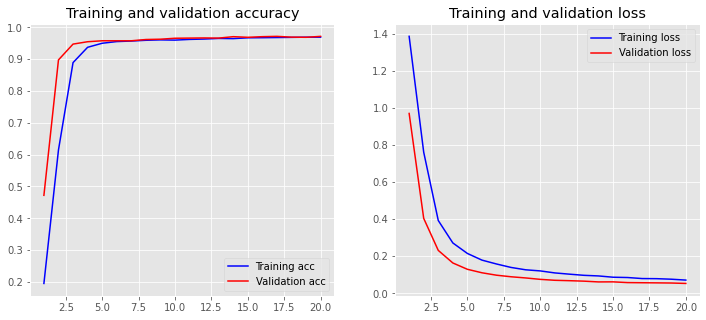

In [46]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [47]:
word_index

{' <eow>': 2,
 "'": 51,
 '*': 53,
 '-': 39,
 '6': 57,
 '8': 56,
 '</w>': 42,
 '<sow> ': 1,
 'a': 6,
 'an': 31,
 'ar': 32,
 'b': 22,
 'be': 35,
 'c': 12,
 'co': 33,
 'd': 14,
 'd</w>': 46,
 'do': 45,
 'e': 13,
 'e</w>': 47,
 'ed</w>': 3,
 'en': 27,
 'er': 21,
 'f': 20,
 'g': 18,
 'h': 19,
 'ha': 37,
 'i': 4,
 'in': 28,
 'ing': 48,
 'j': 43,
 'k': 25,
 'l': 9,
 'll': 36,
 'm': 16,
 'n': 17,
 'o': 7,
 'ow': 44,
 'p': 15,
 'q': 41,
 'r': 11,
 're': 23,
 's': 8,
 'st': 29,
 't': 5,
 't</w>': 40,
 'u': 10,
 'v': 26,
 've</w>': 50,
 'w': 30,
 'x': 38,
 'y': 34,
 'z': 24,
 'æ': 49,
 'ë': 54,
 'ô': 55,
 'œ': 52}

In [93]:
char_lookup = dict((v,k) for k,v in word_index.items())
char_lookup[0] = ""
test_pred = transformer.predict(test_ds, verbose=1)
pred_inflection = []
for word in test_pred:
  character = []
  for letter in word:
    index = np.argmax(letter)
    char = char_lookup[index]
    if index == 0:
      break
    character.append(char)
  inflection = "".join(character)
  pred_inflection.append(inflection)

7/7 [==============================] - 0s 18ms/step


In [105]:
df_test['pred'] = [x.replace('</w>','').replace('<eow>','').replace(' ','') for x in pred_inflection]
df_test['Acc'] = np.where(df_test['inflection'] == df_test['pred'], 1,0)

In [103]:
df_test['inflection'][1]

'conscripted'

In [106]:
df_test['pred'][1]

'conscripted'

In [107]:
sum(df_test['Acc'])/len(df_test)

0.8918918918918919

In [ ]:
df_test[df_test['Acc'] !=1]

In [109]:
df_test.to_csv('BPE_30_Prediction_Past_tense.csv')
!cp BPE_30_Prediction_Past_tense.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'